# Lesson 4 - Fast ai

In [1]:
import utils; reload(utils)
from utils import *
from __future__ import division, print_function
%matplotlib inline


Using Theano backend.


In [2]:
#reload(sys)
#sys.setdefaultencoding('utf8')


In [3]:
path = "../data/ml-small/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)
batch_size=64

In [4]:

ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [5]:
len(ratings)

100004

In [6]:
movie_names = pd.read_csv(path+'movies.csv').set_index('movieId')['title'].to_dict()

In [7]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

In [8]:
#label the id and swop the id for both user and movies 
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

In [9]:
#change to the common index
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

In [10]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), 
    ratings.userId.max(), ratings.movieId.min(), ratings.movieId.max())
user_min, user_max, movie_min, movie_max

(0, 670, 0, 9065)

In [11]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(671, 9066)

Number of latent factors to use

In [12]:
n_factors = 50


In [13]:
#set seed
np.random.seed = 42


In [14]:
#split to training and validation set
msk = np.random.rand(len(ratings)) < 0.8
trn = ratings[msk]
val = ratings[~msk]

### Example

In [15]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

In [16]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

In [17]:
top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')


In [18]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,27,49,57,72,79,89,92,99,143,179,180,197,402,417,505
userId,,,,,,,,,,,,,,,
14,3.0,5.0,1.0,3.0,4.0,4.0,5.0,2.0,5.0,5.0,4.0,5.0,5.0,2.0,5.0
29,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,3.0,4.0,5.0
72,4.0,5.0,5.0,4.0,5.0,3.0,4.5,5.0,4.5,5.0,5.0,5.0,4.5,5.0,4.0
211,5.0,4.0,4.0,3.0,5.0,3.0,4.0,4.5,4.0,NaN,3.0,3.0,5.0,3.0,NaN
212,2.5,NaN,2.0,5.0,NaN,4.0,2.5,NaN,5.0,5.0,3.0,3.0,4.0,3.0,2.0
293,3.0,NaN,4.0,4.0,4.0,3.0,NaN,3.0,4.0,4.0,4.5,4.0,4.5,4.0,NaN
310,3.0,3.0,5.0,4.5,5.0,4.5,2.0,4.5,4.0,3.0,4.5,4.5,4.0,3.0,4.0
379,5.0,5.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,4.0,NaN,3.0,5.0,4.0,4.0
451,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,2.0,3.5,5.0


# Start of Keras 

In [19]:
user_in = Input(shape=(1,), dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, input_length=1, W_regularizer=l2(1e-4))(user_in)
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1, W_regularizer=l2(1e-4))(movie_in)

In [20]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [21]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, verbose = 2,
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79953 samples, validate on 20051 samples
Epoch 1/1
9s - loss: 10.0873 - val_loss: 3.9787


In [22]:
model.optimizer.lr=0.01


In [23]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=3, verbose =2,
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79953 samples, validate on 20051 samples
Epoch 1/3
13s - loss: 3.1792 - val_loss: 2.0460
Epoch 2/3
13s - loss: 2.4097 - val_loss: 1.6583
Epoch 3/3
13s - loss: 2.2238 - val_loss: 1.5320


In [24]:
model.optimizer.lr=0.001


In [25]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, verbose=2,
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79953 samples, validate on 20051 samples
Epoch 1/6
13s - loss: 2.1507 - val_loss: 1.4787
Epoch 2/6
13s - loss: 2.1101 - val_loss: 1.4620
Epoch 3/6
13s - loss: 2.0826 - val_loss: 1.4494
Epoch 4/6
13s - loss: 2.0601 - val_loss: 1.4562
Epoch 5/6
13s - loss: 2.0405 - val_loss: 1.4535
Epoch 6/6
13s - loss: 2.0216 - val_loss: 1.4543


## Adding bias

In [26]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

In [27]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [28]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [29]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

In [30]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
x = merge([x, ub], mode='sum')
x = merge([x, mb], mode='sum')
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [32]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, verbose = 2,
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79953 samples, validate on 20051 samples
Epoch 1/1
9s - loss: 8.8438 - val_loss: 3.1985


In [33]:
model.optimizer.lr=0.01
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, verbose =2,
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79953 samples, validate on 20051 samples
Epoch 1/6
13s - loss: 2.5896 - val_loss: 1.6449
Epoch 2/6
13s - loss: 1.9787 - val_loss: 1.3457
Epoch 3/6
13s - loss: 1.8144 - val_loss: 1.2439
Epoch 4/6
13s - loss: 1.7216 - val_loss: 1.1877
Epoch 5/6
13s - loss: 1.6461 - val_loss: 1.1527
Epoch 6/6
13s - loss: 1.5734 - val_loss: 1.1239


In [34]:
model.optimizer.lr=0.001
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=25, verbose =2,
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79953 samples, validate on 20051 samples
Epoch 1/25
13s - loss: 1.5052 - val_loss: 1.0950
Epoch 2/25
13s - loss: 1.4366 - val_loss: 1.0714
Epoch 3/25
13s - loss: 1.3697 - val_loss: 1.0497
Epoch 4/25
13s - loss: 1.3059 - val_loss: 1.0208
Epoch 5/25
13s - loss: 1.2420 - val_loss: 1.0033
Epoch 6/25
13s - loss: 1.1815 - val_loss: 0.9830
Epoch 7/25
13s - loss: 1.1250 - val_loss: 0.9627
Epoch 8/25
13s - loss: 1.0698 - val_loss: 0.9414
Epoch 9/25
14s - loss: 1.0180 - val_loss: 0.9264
Epoch 10/25
14s - loss: 0.9684 - val_loss: 0.9119
Epoch 11/25
14s - loss: 0.9226 - val_loss: 0.8984
Epoch 12/25
14s - loss: 0.8789 - val_loss: 0.8834
Epoch 13/25
14s - loss: 0.8382 - val_loss: 0.8717
Epoch 14/25
14s - loss: 0.8009 - val_loss: 0.8626
Epoch 15/25
14s - loss: 0.7661 - val_loss: 0.8512
Epoch 16/25
14s - loss: 0.7343 - val_loss: 0.8430
Epoch 17/25
14s - loss: 0.7063 - val_loss: 0.8362
Epoch 18/25
14s - loss: 0.6806 - val_loss: 0.8299
Epoch 19/25
15s - loss: 0.6578 - val_loss: 0.8245
Epoch 20/

In [35]:
model.save_weights(model_path+'bias.h5')


In [36]:
model.load_weights(model_path+'bias.h5')


In [37]:
model.predict([np.array([3]), np.array([6])])


array([[ 4.867]], dtype=float32)

## Analyzing results

- restrict to top 2000 popular movies

In [38]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:2000]
topMovies = np.array(topMovies.index)

In [39]:
get_movie_bias = Model(movie_in, mb)
movie_bias = get_movie_bias.predict(topMovies)

In [40]:
movie_ratings = [(b[0], movie_names[movies[i]]) for i,b in zip(topMovies,movie_bias)]


In [41]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.81828368, 'Battlefield Earth (2000)'),
 (-0.42821428, 'Jaws 3-D (1983)'),
 (-0.37884015, '2 Fast 2 Furious (Fast and the Furious 2, The) (2003)'),
 (-0.32067525, 'Spice World (1997)'),
 (-0.31504393, 'Police Academy 6: City Under Siege (1989)'),
 (-0.25913587, 'Super Mario Bros. (1993)'),
 (-0.23902531, "Charlie's Angels: Full Throttle (2003)"),
 (-0.23847707, 'Speed 2: Cruise Control (1997)'),
 (-0.23351009, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.21582167, 'Police Academy 3: Back in Training (1986)'),
 (-0.21454465, 'Howard the Duck (1986)'),
 (-0.19908662, 'Hollow Man (2000)'),
 (-0.19350226, 'Inspector Gadget (1999)'),
 (-0.18949482, 'Police Academy 4: Citizens on Patrol (1987)'),
 (-0.17388295, 'Mighty Morphin Power Rangers: The Movie (1995)')]

In [42]:
sorted(movie_ratings, key=itemgetter(0),reverse=True)[:15]

[(1.7910264, 'Shawshank Redemption, The (1994)'),
 (1.715112, 'In the Name of the Father (1993)'),
 (1.7076939, 'Modern Times (1936)'),
 (1.6872604, 'The Imitation Game (2014)'),
 (1.6760639, 'On the Waterfront (1954)'),
 (1.6745621, 'Tom Jones (1963)'),
 (1.6594847, 'Shadowlands (1993)'),
 (1.6397665, 'Cinema Paradiso (Nuovo cinema Paradiso) (1989)'),
 (1.6308324, "Amores Perros (Love's a Bitch) (2000)"),
 (1.6290569, 'Grand Day Out with Wallace and Gromit, A (1989)'),
 (1.6267782, 'Godfather, The (1972)'),
 (1.6234528, 'American Movie (1999)'),
 (1.6080184, 'Philadelphia Story, The (1940)'),
 (1.6051148, 'Band of Brothers (2001)'),
 (1.5962727, 'Mister Roberts (1955)')]

In [43]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 50)

In [44]:

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [45]:
fac0 = movie_pca[0]
fac1 = movie_pca[1]
fac2 = movie_pca[2]

In [46]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac0, topMovies)]
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]


[(0.068229081887359391, 'Anaconda (1997)'),
 (0.048167799649241422, 'Ace Ventura: When Nature Calls (1995)'),
 (0.047085759845310216, 'Armageddon (1998)'),
 (0.041193848031832334, 'Independence Day (a.k.a. ID4) (1996)'),
 (0.040731490519416491, 'Batman Forever (1995)'),
 (0.039493733943039309, 'Net, The (1995)'),
 (0.038021760283266141, 'Striptease (1996)'),
 (0.036630092527580621, 'X-Men Origins: Wolverine (2009)'),
 (0.036464433467739962, 'Eraser (1996)'),
 (0.035521893096070435, 'Waterworld (1995)')]

In [53]:
reload(sys)
sys.setdefaultencoding('utf8')

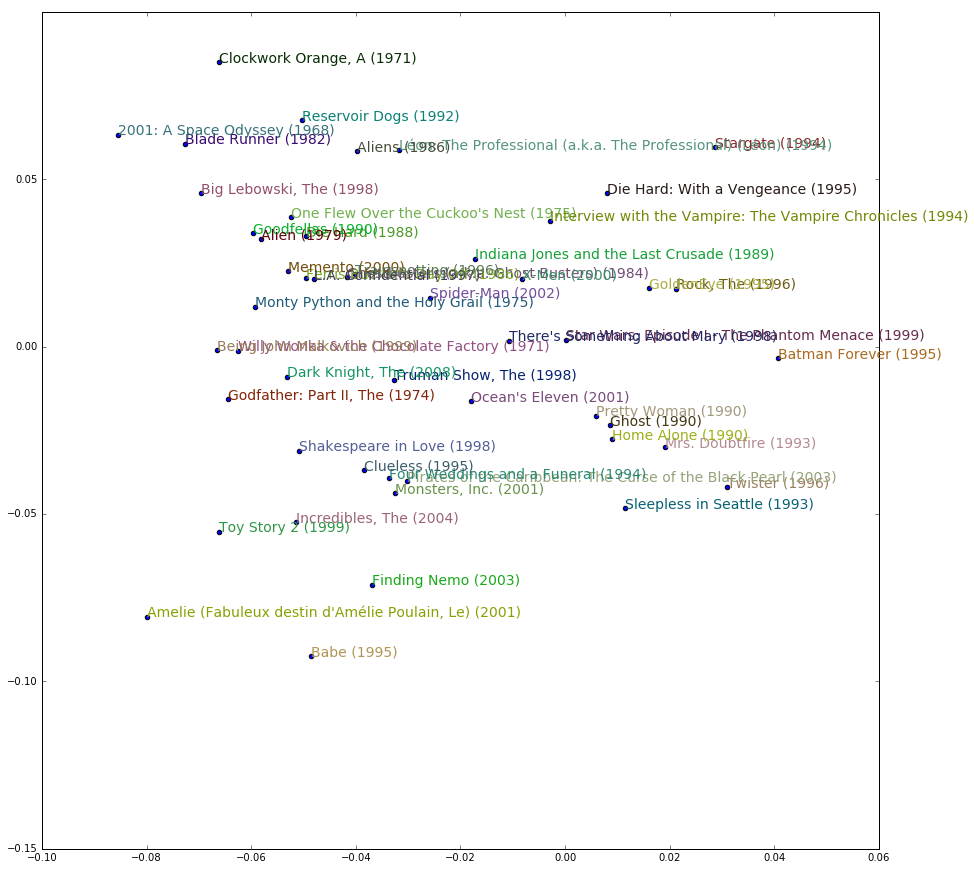

In [54]:
start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

## Neural Network

In [49]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [50]:
x = merge([u, m], mode='concat')
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

In [51]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=8, verbose= 2,
          validation_data=([val.userId, val.movieId], val.rating))

Train on 79953 samples, validate on 20051 samples
Epoch 1/8
11s - loss: 2.3473 - val_loss: 0.8912
Epoch 2/8
25s - loss: 1.4292 - val_loss: 0.9067
Epoch 3/8
20s - loss: 1.2025 - val_loss: 0.8398
Epoch 4/8
20s - loss: 1.0263 - val_loss: 0.8329
Epoch 5/8
26s - loss: 0.9118 - val_loss: 0.8156
Epoch 6/8
24s - loss: 0.8426 - val_loss: 0.8089
Epoch 7/8
30s - loss: 0.8167 - val_loss: 0.8077
Epoch 8/8
35s - loss: 0.8057 - val_loss: 0.8137


In [52]:
nn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_7 (Embedding)          (None, 1, 50)         33550       user_in[0][0]                    
____________________________________________________________________________________________________
embedding_8 (Embedding)          (None, 1, 50)         453300      movie_in[0][0]                   
___________________________________________________________________________________________